In [24]:
from pathlib import Path
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

ROOT = Path("/Users/yizj/Desktop/HBN/pheno_assessment").resolve()
RAW_DIR = ROOT / "data" / "raw"
INTERIM_DIR = ROOT / "data" / "interim"
SYNTH_DIR = ROOT / "data" / "synth"
REPORTS_DIR = ROOT / "data" / "reports"

for d in [INTERIM_DIR, SYNTH_DIR, REPORTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

RAW_DIR, INTERIM_DIR, SYNTH_DIR, REPORTS_DIR


(PosixPath('/Users/yizj/Desktop/HBN/pheno_assessment/data/raw'),
 PosixPath('/Users/yizj/Desktop/HBN/pheno_assessment/data/interim'),
 PosixPath('/Users/yizj/Desktop/HBN/pheno_assessment/data/synth'),
 PosixPath('/Users/yizj/Desktop/HBN/pheno_assessment/data/reports'))

In [2]:
MISSING_TOKENS = {"", "NULL", "null", "NaN", "nan"}

def load_hbn_assessment(path: Path, standardize_cols=True) -> pd.DataFrame:
    # read all as strings first (stable)
    df = pd.read_csv(path, dtype=str, keep_default_na=False)

    if "Identifiers" not in df.columns:
        raise ValueError(f"{path.name}: expected column 'Identifiers' not found.")

    # drop template row(s): Identifiers like ",assessment"
    df = df[~df["Identifiers"].str.startswith(",", na=False)].copy()

    # split Identifiers -> subject_id,eventname
    parts = df["Identifiers"].str.split(",", n=1, expand=True)
    df["subject_id"] = parts[0].str.strip()
    df["eventname"]  = parts[1].str.strip()

    # normalize missing tokens
    df = df.replace({tok: np.nan for tok in MISSING_TOKENS})

    # standardize header commas for code safety (optional)
    if standardize_cols:
        df.columns = [c.replace(",", "_") for c in df.columns]

    return df

In [3]:
def numericize(df: pd.DataFrame, cols):
    out = df.copy()
    for c in cols:
        out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

In [4]:
import re

META_HINTS = [
    "Administration", "Comment", "Data_entry", "Days_Baseline", "EID", "PSCID",
    "START_DATE", "Season", "Site", "Study", "Visit_label", "Year"
]

# Item patterns across instruments:
# CBCL: CBCL_01, CBCL_113A, CBCLpre_100a, etc.
# These are "item-level" (not aggregates).
ITEM_PATTERNS = [
    re.compile(r".*_[0-9]+[A-Za-z]*$"),          # ..._01, ..._113A
    re.compile(r".*_100[a-z]$"),                 # ..._100a, ..._100b
    re.compile(r".*_(pre_)?[0-9]+[A-Za-z]*$"),   # a bit more permissive for pre variants
]

def is_meta_col(col: str) -> bool:
    return any(h in col for h in META_HINTS) or col in {"Identifiers", "subject_id", "eventname"}

_item_index_re = re.compile(r"^(?P<prefix>.+)_(?P<idx>\d{1,3})(?P<suf>[A-Za-z]?)$")

def is_item_col(col: str, prefix: str) -> bool:
    if not col.startswith(prefix + "_"):
        return False
    m = _item_index_re.match(col)
    if not m:
        return False
    idx = int(m.group("idx"))
    # plausible item index range; adjust if needed
    return 1 <= idx <= 250

def get_aggregate_cols(df: pd.DataFrame, prefix: str):
    """
    Aggregate columns = instrument-derived summary scores/subscales/etc.
    Includes things like:
      - NLES_P_TotalEvents, NLES_P_Aware, NLES_P_Upset_Total, ...
      - SCARED_P_GD, SCARED_P_Total, ...
      - CBCL_Pre_DSM_ADHP, CBCL_Pre_Total_T, CBCL_Pre_OP, ...
    Excludes metadata and item-level responses.
    """
    cols = []
    for c in df.columns:
        if is_meta_col(c):
            continue
        if not c.startswith(prefix + "_"):
            continue
        if is_item_col(c, prefix):
            continue
        cols.append(c)
    return cols

def extract_aggregates(df: pd.DataFrame, file_tag: str) -> pd.DataFrame:
    prefix = infer_prefix_with_check(df)
    agg_cols = get_aggregate_cols(df, prefix)

    # numeric conversion only for aggregate cols
    df_num = numericize(df, agg_cols)

    out = df_num[["subject_id", "eventname"]].copy()

    for c in agg_cols:
        out[f"{file_tag}__{c}"] = df_num[c]

    return out

In [5]:
from collections import Counter

def infer_prefix(df: pd.DataFrame) -> str:
    admin_cols = [c for c in df.columns if c.endswith("_Administration")]
    if admin_cols:
        return admin_cols[0].replace("_Administration", "")

    # fallback: most frequent prefix among non-meta columns
    candidates = []
    for c in df.columns:
        if c in {"Identifiers", "subject_id", "eventname"}:
            continue
        if is_meta_col(c):
            continue
        if "_" in c:
            candidates.append("_".join(c.split("_")[:2]) if c.count("_") >= 2 else c.split("_")[0])
    if candidates:
        return Counter(candidates).most_common(1)[0][0]
    return "INSTR"

def infer_prefix_with_check(df):
    prefix = infer_prefix(df)
    agg = get_aggregate_cols(df, prefix)
    if len(agg) == 0:
        # fallback: try the most frequent 1-token prefix as well
        one_tok = []
        for c in df.columns:
            if is_meta_col(c): 
                continue
            if "_" in c:
                one_tok.append(c.split("_")[0])
        if one_tok:
            prefix2 = Counter(one_tok).most_common(1)[0][0]
            agg2 = get_aggregate_cols(df, prefix2)
            if len(agg2) > 0:
                return prefix2
    return prefix

def sanity_keys(df, name="df"):
    assert "subject_id" in df.columns and "eventname" in df.columns, f"{name}: missing keys"
    assert df["subject_id"].notna().all(), f"{name}: null subject_id"
    # eventname can be null if parsing fails; flag it:
    if df["eventname"].isna().mean() > 0:
        print(f"WARNING {name}: eventname missing rate = {df['eventname'].isna().mean():.3f}")
    dup = df.duplicated(subset=["subject_id","eventname"]).mean()
    if dup > 0:
        print(f"WARNING {name}: duplicate key rate = {dup:.4f}")

In [9]:
files = [
    "AdverseChildhoodExperiencesScale_child.csv",
    "AdverseChildhoodExperiencesScale_parent.csv",
    "ChildBehaviorChecklist_parent.csv",
    "ChildBehaviorChecklist_parentPreschool.csv",
    "ChildrensDepressionInventory_child.csv",
    "ChildrensDepressionInventory_parent.csv",
    "ConnersADHDRatingScales.csv",
    "ConnersAdultADHDRatingScales.csv",
    "NegativeLifeEventsScale_child.csv",
    "NegativeLifeEventsScale_parent.csv",
    "ScreenForChildAnxietyRelatedDisorders_child.csv",
    "ScreenForChildAnxietyRelatedDisorders_parent.csv",
    "StateTraitAnxietyInventory.csv",
]

dfs = {}
for fn in files:
    p = RAW_DIR / fn
    if not p.exists():
        print("MISSING:", fn)
        continue
    df = load_hbn_assessment(p, standardize_cols=True)
    dfs[fn] = df
    print(fn, df.shape, "prefix:", infer_prefix(df))

/var/folders/4_/vsf2fnhd3bz458z2nvlnyrmm0000gn/T/ipykernel_14967/54876077.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({tok: np.nan for tok in MISSING_TOKENS})
/var/folders/4_/vsf2fnhd3bz458z2nvlnyrmm0000gn/T/ipykernel_14967/54876077.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({tok: np.nan for tok in MISSING_TOKENS})
/var/folders/4_/vsf2fnhd3bz458z2nvlnyrmm0000gn/T/ipykernel_14967/54876077.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a

AdverseChildhoodExperiencesScale_child.csv (77, 26) prefix: ACE
AdverseChildhoodExperiencesScale_parent.csv (2197, 33) prefix: ACE_P
ChildBehaviorChecklist_parent.csv (4301, 161) prefix: CBCL
ChildBehaviorChecklist_parentPreschool.csv (161, 146) prefix: CBCL_Pre
ChildrensDepressionInventory_child.csv (175, 57) prefix: CDI_SR
ChildrensDepressionInventory_parent.csv (210, 92) prefix: CDI_P
ConnersADHDRatingScales.csv (3256, 66) prefix: C3SR
ConnersAdultADHDRatingScales.csv (121, 51) prefix: CAARS
NegativeLifeEventsScale_child.csv (1251, 85) prefix: NLES_SR
NegativeLifeEventsScale_parent.csv (4148, 82) prefix: NLES_P
ScreenForChildAnxietyRelatedDisorders_child.csv (3187, 62) prefix: SCARED_SR


/var/folders/4_/vsf2fnhd3bz458z2nvlnyrmm0000gn/T/ipykernel_14967/54876077.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({tok: np.nan for tok in MISSING_TOKENS})
/var/folders/4_/vsf2fnhd3bz458z2nvlnyrmm0000gn/T/ipykernel_14967/54876077.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({tok: np.nan for tok in MISSING_TOKENS})
/var/folders/4_/vsf2fnhd3bz458z2nvlnyrmm0000gn/T/ipykernel_14967/54876077.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a

ScreenForChildAnxietyRelatedDisorders_parent.csv (4177, 151) prefix: CDI_P
StateTraitAnxietyInventory.csv (73, 61) prefix: STAI


/var/folders/4_/vsf2fnhd3bz458z2nvlnyrmm0000gn/T/ipykernel_14967/54876077.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({tok: np.nan for tok in MISSING_TOKENS})


In [10]:
df = dfs["ChildBehaviorChecklist_parentPreschool.csv"]
prefix = infer_prefix_with_check(df)
agg_cols = get_aggregate_cols(df, prefix)
prefix, len(agg_cols), agg_cols[:30]

('CBCL_Pre',
 29,
 ['CBCL_Pre_CBCLPre_AB',
  'CBCL_Pre_CBCLPre_AB_T',
  'CBCL_Pre_CBCLPre_AD',
  'CBCL_Pre_CBCLPre_AD_T',
  'CBCL_Pre_CBCLPre_AP',
  'CBCL_Pre_CBCLPre_AP_T',
  'CBCL_Pre_CBCLPre_DSM_ADHP',
  'CBCL_Pre_CBCLPre_DSM_ADHP_T',
  'CBCL_Pre_CBCLPre_DSM_AP',
  'CBCL_Pre_CBCLPre_DSM_AP_T',
  'CBCL_Pre_CBCLPre_DSM_AnxP',
  'CBCL_Pre_CBCLPre_DSM_AnxP_T',
  'CBCL_Pre_CBCLPre_DSM_ODP',
  'CBCL_Pre_CBCLPre_DSM_ODP_T',
  'CBCL_Pre_CBCLPre_DSM_PDP',
  'CBCL_Pre_CBCLPre_DSM_PDP_T',
  'CBCL_Pre_CBCLPre_Ext',
  'CBCL_Pre_CBCLPre_Ext_T',
  'CBCL_Pre_CBCLPre_Int',
  'CBCL_Pre_CBCLPre_Int_T',
  'CBCL_Pre_CBCLPre_OP',
  'CBCL_Pre_CBCLPre_SC',
  'CBCL_Pre_CBCLPre_SC_T',
  'CBCL_Pre_CBCLPre_SP',
  'CBCL_Pre_CBCLPre_SP_T',
  'CBCL_Pre_CBCLPre_Total',
  'CBCL_Pre_CBCLPre_Total_T',
  'CBCL_Pre_CBCLPre_WD',
  'CBCL_Pre_CBCLPre_WD_T'])

 Extract per-instrument aggregate tables (in memory)

In [11]:
agg_by_file = {}
meta_rows = []

for fn, df in dfs.items():
    tag = Path(fn).stem  # e.g., ChildBehaviorChecklist_parent
    agg = extract_aggregates(df, file_tag=tag)

    # basic key sanity
    sanity_keys(agg, name=tag)

    # duplicate key rate
    dup_rate = agg.duplicated(subset=["subject_id", "eventname"]).mean()

    meta_rows.append({
        "file": fn,
        "tag": tag,
        "n_rows": len(agg),
        "n_cols": agg.shape[1],
        "n_agg_cols": agg.shape[1] - 2,
        "dup_key_rate": dup_rate,
        "eventname_unique": agg["eventname"].nunique(dropna=True),
    })

    agg_by_file[fn] = agg
    print(f"{tag}: {agg.shape} | dup_key_rate={dup_rate:.4f}")

meta_df = pd.DataFrame(meta_rows).sort_values("n_agg_cols", ascending=False)
meta_df.head(20)

AdverseChildhoodExperiencesScale_child: (77, 3) | dup_key_rate=0.0000
AdverseChildhoodExperiencesScale_parent: (2197, 3) | dup_key_rate=0.0000
ChildBehaviorChecklist_parent: (4301, 26) | dup_key_rate=0.0000
ChildBehaviorChecklist_parentPreschool: (161, 31) | dup_key_rate=0.0000
ChildrensDepressionInventory_child: (175, 16) | dup_key_rate=0.0000
ChildrensDepressionInventory_parent: (210, 8) | dup_key_rate=0.0000
ConnersADHDRatingScales: (3256, 14) | dup_key_rate=0.0000
ConnersAdultADHDRatingScales: (121, 12) | dup_key_rate=0.0000
NegativeLifeEventsScale_child: (1251, 6) | dup_key_rate=0.0000
NegativeLifeEventsScale_parent: (4148, 6) | dup_key_rate=0.0000
ScreenForChildAnxietyRelatedDisorders_child: (3187, 8) | dup_key_rate=0.0000
ScreenForChildAnxietyRelatedDisorders_parent: (4177, 8) | dup_key_rate=0.0000
StateTraitAnxietyInventory: (73, 8) | dup_key_rate=0.0000


,file,tag,n_rows,n_cols,n_agg_cols,dup_key_rate,eventname_unique
3,ChildBehaviorChecklist_parentPreschool.csv,ChildBehaviorChecklist_parentPreschool,161,31,29,0.0,1
2,ChildBehaviorChecklist_parent.csv,ChildBehaviorChecklist_parent,4301,26,24,0.0,1
4,ChildrensDepressionInventory_child.csv,ChildrensDepressionInventory_child,175,16,14,0.0,1
6,ConnersADHDRatingScales.csv,ConnersADHDRatingScales,3256,14,12,0.0,1
7,ConnersAdultADHDRatingScales.csv,ConnersAdultADHDRatingScales,121,12,10,0.0,1
5,ChildrensDepressionInventory_parent.csv,ChildrensDepressionInventory_parent,210,8,6,0.0,1
10,ScreenForChildAnxietyRelatedDisorders_child.csv,ScreenForChildAnxietyRelatedDisorders_child,3187,8,6,0.0,1
11,ScreenForChildAnxietyRelatedDisorders_parent.csv,ScreenForChildAnxietyRelatedDisorders_parent,4177,8,6,0.0,1
12,StateTraitAnxietyInventory.csv,StateTraitAnxietyInventory,73,8,6,0.0,1
8,NegativeLifeEventsScale_child.csv,NegativeLifeEventsScale_child,1251,6,4,0.0,1


Export REAL aggregate tables to data/interim/

Each file becomes: data/interim/<instrument>_aggregates.csv

In [12]:
written = []

for fn, agg in agg_by_file.items():
    tag = Path(fn).stem
    out_path = INTERIM_DIR / f"{tag}_aggregates.csv"
    agg.to_csv(out_path, index=False)
    written.append({"file": fn, "interim_path": str(out_path), "rows": len(agg), "cols": agg.shape[1]})

written_df = pd.DataFrame(written)
written_df.to_csv(REPORTS_DIR / "interim_aggregate_exports.csv", index=False)

print("Wrote", len(written_df), "aggregate tables to", INTERIM_DIR)
written_df.head(10)

Wrote 13 aggregate tables to /Users/yizj/Desktop/HBN/pheno_assessment/data/interim


,file,interim_path,rows,cols
0,AdverseChildhoodExperiencesScale_child.csv,/Users/yizj/Desktop/HBN/pheno_assessment/data/...,77,3
1,AdverseChildhoodExperiencesScale_parent.csv,/Users/yizj/Desktop/HBN/pheno_assessment/data/...,2197,3
2,ChildBehaviorChecklist_parent.csv,/Users/yizj/Desktop/HBN/pheno_assessment/data/...,4301,26
3,ChildBehaviorChecklist_parentPreschool.csv,/Users/yizj/Desktop/HBN/pheno_assessment/data/...,161,31
4,ChildrensDepressionInventory_child.csv,/Users/yizj/Desktop/HBN/pheno_assessment/data/...,175,16
5,ChildrensDepressionInventory_parent.csv,/Users/yizj/Desktop/HBN/pheno_assessment/data/...,210,8
6,ConnersADHDRatingScales.csv,/Users/yizj/Desktop/HBN/pheno_assessment/data/...,3256,14
7,ConnersAdultADHDRatingScales.csv,/Users/yizj/Desktop/HBN/pheno_assessment/data/...,121,12
8,NegativeLifeEventsScale_child.csv,/Users/yizj/Desktop/HBN/pheno_assessment/data/...,1251,6
9,NegativeLifeEventsScale_parent.csv,/Users/yizj/Desktop/HBN/pheno_assessment/data/...,4148,6


Mapping from original subject_id → synthetic subject_id

This keeps joinability without revealing original IDs (as long as U keep the mapping private).

In [45]:
def make_subject_id_map(all_subject_ids, prefix="SYN_SUBJ", seed=0):
    rng = np.random.default_rng(seed)
    unique_ids = pd.Series(pd.unique(all_subject_ids)).dropna().astype(str).tolist()
    rng.shuffle(unique_ids)
    mapped = {sid: f"{prefix}_{i:06d}" for i, sid in enumerate(unique_ids)}
    return mapped

Then build a map from all interim aggregate tables (or from the raw subject_id universe):

In [46]:
# collect all subject_ids across your real aggregate tables
all_ids = []
for fn, real_agg in agg_by_file.items():
    all_ids.append(real_agg["subject_id"].astype(str).values)
all_ids = np.concatenate(all_ids)

id_map = make_subject_id_map(all_ids, prefix="SYN_SUBJ", seed=123)

Synthetic per-instrument aggregates (same schema, safe IDs)

This preserves marginal distributions and missingness patterns. It also keeps joinability across instruments optional; since you’re doing per-instrument, we’ll generate IDs per instrument (privacy-safe). If later you want cross-instrument joins, tell me and I’ll switch to a shared synthetic ID spine.

In [47]:
def synth_bootstrap_table(df: pd.DataFrame, id_map: dict, seed: int = 0):
    syn = df.sample(n=len(df), replace=True, random_state=seed).reset_index(drop=True)
    syn["subject_id"] = syn["subject_id"].astype(str).map(id_map)
    return syn

synth_by_file = {}
written_synth = []

for i, (fn, real_agg) in enumerate(agg_by_file.items()):
    tag = Path(fn).stem
    syn = synth_bootstrap_table(real_agg, id_map=id_map, seed=42 + i)

    # ensure schema match
    assert list(syn.columns) == list(real_agg.columns), f"Schema mismatch for {tag}"

    synth_by_file[fn] = syn

    out_path = SYNTH_DIR / f"{tag}_aggregates.csv"
    syn.to_csv(out_path, index=False)
    written_synth.append({"file": fn, "synth_path": str(out_path), "rows": len(syn), "cols": syn.shape[1]})

written_synth_df = pd.DataFrame(written_synth)
written_synth_df.to_csv(REPORTS_DIR / "synth_aggregate_exports.csv", index=False)

print("Wrote", len(written_synth_df), "synthetic aggregate tables to", SYNTH_DIR)
written_synth_df.head(10)

Wrote 13 synthetic aggregate tables to /Users/yizj/Desktop/HBN/pheno_assessment/data/synth


,file,synth_path,rows,cols
0,AdverseChildhoodExperiencesScale_child.csv,/Users/yizj/Desktop/HBN/pheno_assessment/data/...,77,3
1,AdverseChildhoodExperiencesScale_parent.csv,/Users/yizj/Desktop/HBN/pheno_assessment/data/...,2197,3
2,ChildBehaviorChecklist_parent.csv,/Users/yizj/Desktop/HBN/pheno_assessment/data/...,4301,26
3,ChildBehaviorChecklist_parentPreschool.csv,/Users/yizj/Desktop/HBN/pheno_assessment/data/...,161,31
4,ChildrensDepressionInventory_child.csv,/Users/yizj/Desktop/HBN/pheno_assessment/data/...,175,16
5,ChildrensDepressionInventory_parent.csv,/Users/yizj/Desktop/HBN/pheno_assessment/data/...,210,8
6,ConnersADHDRatingScales.csv,/Users/yizj/Desktop/HBN/pheno_assessment/data/...,3256,14
7,ConnersAdultADHDRatingScales.csv,/Users/yizj/Desktop/HBN/pheno_assessment/data/...,121,12
8,NegativeLifeEventsScale_child.csv,/Users/yizj/Desktop/HBN/pheno_assessment/data/...,1251,6
9,NegativeLifeEventsScale_parent.csv,/Users/yizj/Desktop/HBN/pheno_assessment/data/...,4148,6


Validation report: missingness + summary stats


In [48]:
def summarize_numeric(df: pd.DataFrame):
    num = df.drop(columns=["subject_id","eventname"], errors="ignore")
    # all should be numeric already, but coerce just in case
    num = num.apply(pd.to_numeric, errors="coerce")
    return pd.DataFrame({
        "missing_rate": num.isna().mean(),
        "mean": num.mean(),
        "std": num.std(),
        "p01": num.quantile(0.01),
        "p50": num.quantile(0.50),
        "p99": num.quantile(0.99),
        "n_nonmissing": num.notna().sum()
    }).reset_index().rename(columns={"index":"col"})

rows = []
for fn in agg_by_file:
    tag = Path(fn).stem
    real = agg_by_file[fn]
    syn  = synth_by_file[fn]

    real_sum = summarize_numeric(real)
    syn_sum  = summarize_numeric(syn)

    merged = real_sum.merge(syn_sum, on="col", suffixes=("_real","_synth"))
    merged.insert(0, "instrument", tag)
    rows.append(merged)

val_df = pd.concat(rows, ignore_index=True)
val_path = REPORTS_DIR / "real_vs_synth_aggregate_validation.csv"
val_df.to_csv(val_path, index=False)

val_path, val_df.head(20)

(PosixPath('/Users/yizj/Desktop/HBN/pheno_assessment/data/reports/real_vs_synth_aggregate_validation.csv'),
                                  instrument  \
 0    AdverseChildhoodExperiencesScale_child   
 1   AdverseChildhoodExperiencesScale_parent   
 2             ChildBehaviorChecklist_parent   
 3             ChildBehaviorChecklist_parent   
 4             ChildBehaviorChecklist_parent   
 5             ChildBehaviorChecklist_parent   
 6             ChildBehaviorChecklist_parent   
 7             ChildBehaviorChecklist_parent   
 8             ChildBehaviorChecklist_parent   
 9             ChildBehaviorChecklist_parent   
 10            ChildBehaviorChecklist_parent   
 11            ChildBehaviorChecklist_parent   
 12            ChildBehaviorChecklist_parent   
 13            ChildBehaviorChecklist_parent   
 14            ChildBehaviorChecklist_parent   
 15            ChildBehaviorChecklist_parent   
 16            ChildBehaviorChecklist_parent   
 17            ChildBehavior

Reusable utilities for compact summaries and validation plots

In [49]:
KEYS = ["subject_id", "eventname"]

def load_csv(path: Path) -> pd.DataFrame:
    return pd.read_csv(path)

def schema_signature(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame({
        "col": df.columns,
        "dtype": [str(df[c].dtype) for c in df.columns]
    })

def numeric_frame(df: pd.DataFrame) -> pd.DataFrame:
    """Return only numeric-like columns (excluding keys), coerced to numeric."""
    num = df.drop(columns=[c for c in KEYS if c in df.columns], errors="ignore").copy()
    for c in num.columns:
        num[c] = pd.to_numeric(num[c], errors="coerce")
    return num

def compact_univariate_summary(num: pd.DataFrame) -> pd.DataFrame:
    """Compact per-column stats."""
    return pd.DataFrame({
        "n": num.notna().sum(),
        "missing_rate": num.isna().mean(),
        "mean": num.mean(),
        "std": num.std(),
        "p01": num.quantile(0.01),
        "p25": num.quantile(0.25),
        "p50": num.quantile(0.50),
        "p75": num.quantile(0.75),
        "p99": num.quantile(0.99),
    }).reset_index().rename(columns={"index": "col"})

def compare_univariate(real: pd.DataFrame, synth: pd.DataFrame) -> pd.DataFrame:
    r = compact_univariate_summary(numeric_frame(real))
    s = compact_univariate_summary(numeric_frame(synth))
    m = r.merge(s, on="col", how="outer", suffixes=("_real", "_synth"))

    # deltas (absolute and relative where meaningful)
    for metric in ["missing_rate", "mean", "std", "p01", "p25", "p50", "p75", "p99"]:
        m[f"delta_{metric}"] = (m[f"{metric}_synth"] - m[f"{metric}_real"])
    # relative mean/std deltas (avoid divide-by-zero)
    m["rel_delta_mean"] = m["delta_mean"] / (m["mean_real"].abs() + 1e-9)
    m["rel_delta_std"]  = m["delta_std"]  / (m["std_real"].abs()  + 1e-9)

    return m

def top_outliers(diff_df: pd.DataFrame, k=10) -> pd.DataFrame:
    """Show top K columns with largest mismatches."""
    cols = ["col", "missing_rate_real","missing_rate_synth","delta_missing_rate",
            "mean_real","mean_synth","rel_delta_mean",
            "std_real","std_synth","rel_delta_std"]
    keep = [c for c in cols if c in diff_df.columns]
    return (diff_df.assign(abs_miss=diff_df["delta_missing_rate"].abs(),
                           abs_mean=diff_df["rel_delta_mean"].abs(),
                           abs_std=diff_df["rel_delta_std"].abs())
                  .sort_values(["abs_miss","abs_mean","abs_std"], ascending=False)
                  .loc[:, keep]
                  .head(k))

Distribution overlay helpers

It answers question: “Do my synthetic aggregate values ‘look like’ the real ones across the whole instrument?”
Because I was bootstrapping rows, this overlay should be very close.


In [50]:
KEYS = ["subject_id", "eventname"]  # you already have this

def flatten_aggregates(df: pd.DataFrame) -> np.ndarray:
    """
    Flatten all numeric aggregate columns (excluding KEYS) into a 1D array.
    """
    X = df.drop(columns=[c for c in KEYS if c in df.columns], errors="ignore").copy()
    # coerce all to numeric
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")
    vals = X.to_numpy().ravel()
    vals = vals[np.isfinite(vals)]
    return vals

def _auto_bins(x: np.ndarray, max_bins: int = 80) -> int:
    # Freedman–Diaconis rule with fallback
    if len(x) < 2:
        return 10
    q25, q75 = np.percentile(x, [25, 75])
    iqr = q75 - q25
    if iqr <= 0:
        return min(30, max_bins)
    bin_width = 2 * iqr * (len(x) ** (-1/3))
    if bin_width <= 0:
        return min(30, max_bins)
    bins = int(np.ceil((x.max() - x.min()) / bin_width))
    return int(np.clip(bins, 10, max_bins))

def plot_distribution_overlay(
    real: pd.DataFrame,
    synth: pd.DataFrame,
    title: str,
    mode: str = "hist",     # "hist" or "kde"
    clip_quantiles=(0.001, 0.999),  # clip extremes for stable view
):
    """
    One plot per dataset: overlay real vs synth distribution of ALL aggregate values.
    - mode="hist": normalized histogram overlays (recommended; no extra deps)
    - mode="kde": gaussian-kde overlay (uses scipy if available)
    """
    xr = flatten_aggregates(real)
    xs = flatten_aggregates(synth)

    if len(xr) == 0 or len(xs) == 0:
        fig, ax = plt.subplots(figsize=(5.2, 3.0))
        ax.text(0.5, 0.5, "No numeric aggregates found", ha="center", va="center")
        ax.set_axis_off()
        fig.tight_layout()
        return fig

    # clip extremes so plot isn't dominated by outliers
    lo_r, hi_r = np.quantile(xr, clip_quantiles)
    lo_s, hi_s = np.quantile(xs, clip_quantiles)
    lo = min(lo_r, lo_s)
    hi = max(hi_r, hi_s)
    xr_c = xr[(xr >= lo) & (xr <= hi)]
    xs_c = xs[(xs >= lo) & (xs <= hi)]

    fig, ax = plt.subplots(figsize=(5.4, 3.2))

    if mode == "kde":
        try:
            from scipy.stats import gaussian_kde
            kde_r = gaussian_kde(xr_c)
            kde_s = gaussian_kde(xs_c)
            grid = np.linspace(lo, hi, 300)
            ax.plot(grid, kde_r(grid), label="real")
            ax.plot(grid, kde_s(grid), label="synth")
            ax.set_ylabel("density")
        except Exception:
            mode = "hist"  # fall back if scipy not available

    if mode == "hist":
        # common binning to make overlay comparable
        bins = _auto_bins(np.concatenate([xr_c, xs_c]))
        ax.hist(xr_c, bins=bins, density=True, alpha=0.35, label="real")
        ax.hist(xs_c, bins=bins, density=True, alpha=0.35, label="synth")
        ax.set_ylabel("density (hist)")

    ax.set_title(title)
    ax.set_xlabel("aggregate value (pooled across columns)")
    ax.legend(frameon=False)
    fig.tight_layout()
    return fig

Correlation structure functions (compact + robust)

	•	Each point = one pair of aggregate columns (e.g., (SCARED_P_Total, SCARED_P_GD) or (CBCL_Pre_Total_T, CBCL_Pre_DSM_AnxP_T)).
	•	x-axis (corr (real)) = the Pearson correlation between that column-pair computed from the real/interim table.
	•	y-axis (corr (synth)) = the correlation between the same two columns computed from the synthetic table.
	•	If the synthetic preserves multivariate structure, points lie near the diagonal.

This is not per-subject correlation.

overlay plot (pooled distribution) checks univariate faithfulness: “do the values look similar overall?”

But many downstream visualizations/analyses depend on relationships between variables, e.g.:
	•	Total score vs subscales
	•	Two symptom domains moving together
	•	A composite vs its components

Two datasets can have matching marginal distributions but broken relationships if the synth process samples columns independently (or otherwise distorts covariance). Correlation checks catch that quickly.

Given the current synth method is bootstrap row sampling, correlations should match very closely; correlation checks are mainly a safety net against:
	•	accidentally sampling columns independently
	•	accidentally re-coercing types causing subtle numeric changes
	•	accidentally mixing scales or columns during extraction

In [51]:
def corr_matrix(df: pd.DataFrame, min_nonmissing=30, method="pearson") -> pd.DataFrame:
    """
    Correlation matrix across aggregate columns.
    - Drops columns with too few non-missing values
    - Uses pairwise-complete observations via pandas corr()
    """
    X = numeric_frame(df)
    keep = X.columns[X.notna().sum() >= min_nonmissing]
    X = X[keep]
    if X.shape[1] < 2:
        return pd.DataFrame()
    return X.corr(method=method)

def corr_compare_metrics(real: pd.DataFrame, synth: pd.DataFrame, min_nonmissing=30, method="pearson"):
    """
    Returns small, interpretable numbers summarizing how close Corr_synth is to Corr_real.
    """
    Cr = corr_matrix(real, min_nonmissing=min_nonmissing, method=method)
    Cs = corr_matrix(synth, min_nonmissing=min_nonmissing, method=method)

    common = Cr.index.intersection(Cs.index)
    if len(common) < 3:
        return {
            "n_corr_cols": len(common),
            "mean_abs_corr_diff": np.nan,
            "max_abs_corr_diff": np.nan,
            "fro_norm_corr_diff": np.nan,
        }

    Cr = Cr.loc[common, common]
    Cs = Cs.loc[common, common]

    # compare only upper triangle excluding diagonal
    iu = np.triu_indices(len(common), k=1)
    dr = Cr.values[iu]
    ds = Cs.values[iu]
    diff = ds - dr

    return {
        "n_corr_cols": len(common),
        "mean_abs_corr_diff": float(np.nanmean(np.abs(diff))),
        "max_abs_corr_diff": float(np.nanmax(np.abs(diff))),
        "fro_norm_corr_diff": float(np.linalg.norm((Cs - Cr).values, ord="fro")),
    }

def plot_corr_upper_triangle_overlay(real: pd.DataFrame, synth: pd.DataFrame,
                                     title="Correlation overlay", min_nonmissing=30, method="pearson"):
    """
    One compact plot:
    x = real pairwise correlations (upper triangle)
    y = synth pairwise correlations (upper triangle)
    Points near diagonal => correlation structure preserved.
    """
    Cr = corr_matrix(real, min_nonmissing=min_nonmissing, method=method)
    Cs = corr_matrix(synth, min_nonmissing=min_nonmissing, method=method)

    common = Cr.index.intersection(Cs.index)
    if len(common) < 3:
        return None

    Cr = Cr.loc[common, common]
    Cs = Cs.loc[common, common]

    iu = np.triu_indices(len(common), k=1)
    x = Cr.values[iu]
    y = Cs.values[iu]

    fig, ax = plt.subplots(figsize=(4.0, 3.2))
    ax.scatter(x, y, s=10)
    ax.plot([-1, 1], [-1, 1])
    ax.set_xlim([-1, 1]); ax.set_ylim([-1, 1])
    ax.set_xlabel("corr (real)")
    ax.set_ylabel("corr (synth)")
    ax.set_title(f"{title} (n_cols={len(common)})")
    fig.tight_layout()
    return fig

Compact “one dataset” report function (inline)

In [52]:
def validate_one_pair_inline(real: pd.DataFrame, synth: pd.DataFrame, name: str,
                             top_k=8, show_corr=True, min_corr_nonmissing=30,
                             dist_mode="hist"):
    same_cols = list(real.columns) == list(synth.columns)
    header = pd.DataFrame([{
        "dataset": name,
        "rows_real": real.shape[0], "cols_real": real.shape[1],
        "rows_synth": synth.shape[0], "cols_synth": synth.shape[1],
        "same_column_order": same_cols,
    }])
    display(header)

    diff = compare_univariate(real, synth)
    display(top_outliers(diff, k=top_k))

    # Distribution overlay (your main plot)
    fig = plot_distribution_overlay(real, synth,
                                    title=f"{name}: pooled aggregate distribution",
                                    mode=dist_mode)
    display(fig); plt.close(fig)

    # Correlation structure check (across columns)
    if show_corr:
        metrics = corr_compare_metrics(real, synth, min_nonmissing=min_corr_nonmissing)
        display(pd.DataFrame([{"dataset": name, **metrics}]))

        figc = plot_corr_upper_triangle_overlay(real, synth,
                                               title=f"{name}: corr structure",
                                               min_nonmissing=min_corr_nonmissing)
        if figc is not None:
            display(figc); plt.close(figc)

“Do you have enough overlap for correlations?”

Small overlap makes correlation matrices unstable. Compute pairwise overlap counts:

In [53]:
def min_pairwise_n(df, min_cols=2):
    X = numeric_frame(df)
    cols = X.columns
    if len(cols) < min_cols:
        return 0
    nmin = np.inf
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            n = (X[cols[i]].notna() & X[cols[j]].notna()).sum()
            nmin = min(nmin, n)
    return int(nmin) if np.isfinite(nmin) else 0

Collect file pairs (interim ↔ synth)

In [54]:
def list_pairs(interim_dir=INTERIM_DIR, synth_dir=SYNTH_DIR, pattern="*_aggregates.csv"):
    real_paths = sorted(Path(interim_dir).glob(pattern))
    pairs = []
    for rp in real_paths:
        sp = Path(synth_dir) / rp.name
        if sp.exists():
            pairs.append((rp, sp))
        else:
            print("SKIP (no synth match):", rp.name)
    print(f"Found {len(pairs)} pairs.")
    return pairs

pairs = list_pairs()
pairs[:3]

Found 13 pairs.


[(PosixPath('/Users/yizj/Desktop/HBN/pheno_assessment/data/interim/AdverseChildhoodExperiencesScale_child_aggregates.csv'),
  PosixPath('/Users/yizj/Desktop/HBN/pheno_assessment/data/synth/AdverseChildhoodExperiencesScale_child_aggregates.csv')),
 (PosixPath('/Users/yizj/Desktop/HBN/pheno_assessment/data/interim/AdverseChildhoodExperiencesScale_parent_aggregates.csv'),
  PosixPath('/Users/yizj/Desktop/HBN/pheno_assessment/data/synth/AdverseChildhoodExperiencesScale_parent_aggregates.csv')),
 (PosixPath('/Users/yizj/Desktop/HBN/pheno_assessment/data/interim/ChildBehaviorChecklist_parentPreschool_aggregates.csv'),
  PosixPath('/Users/yizj/Desktop/HBN/pheno_assessment/data/synth/ChildBehaviorChecklist_parentPreschool_aggregates.csv'))]

Batch runner over all exported per-instrument aggregates

Assumes files are:
	•	real: data/interim/<instrument>_aggregates.csv
	•	synth: data/synth/<instrument>_aggregates.csv

In [55]:
def run_all_pairs(
    pairs,
    top_k=8,
    show_corr=False,
    min_corr_nonmissing=50,
    limit=None,
    dist_mode="hist",
):
    if limit is not None:
        pairs = pairs[:limit]

    for real_path, synth_path in pairs:
        name = real_path.stem.replace("_aggregates", "")
        real = load_csv(real_path)
        synth = load_csv(synth_path)

        validate_one_pair_inline(
            real, synth, name=name,
            top_k=top_k,
            show_corr=show_corr,
            min_corr_nonmissing=min_corr_nonmissing,
            dist_mode=dist_mode,
        )

,dataset,rows_real,cols_real,rows_synth,cols_synth,same_column_order
0,AdverseChildhoodExperiencesScale_child,77,3,77,3,True


,col,missing_rate_real,missing_rate_synth,delta_missing_rate,mean_real,mean_synth,rel_delta_mean,std_real,std_synth,rel_delta_std
0,AdverseChildhoodExperiencesScale_child__ACE_AC...,0.0,0.0,0.0,1.350649,1.220779,-0.096154,1.579192,1.420002,-0.100805


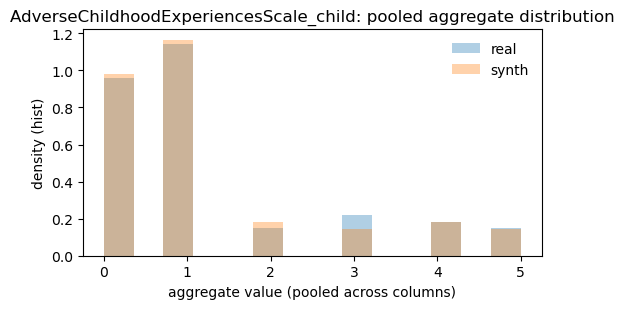

,dataset,n_corr_cols,mean_abs_corr_diff,max_abs_corr_diff,fro_norm_corr_diff
0,AdverseChildhoodExperiencesScale_child,0,NaN,NaN,NaN


,dataset,rows_real,cols_real,rows_synth,cols_synth,same_column_order
0,AdverseChildhoodExperiencesScale_parent,2197,3,2197,3,True


,col,missing_rate_real,missing_rate_synth,delta_missing_rate,mean_real,mean_synth,rel_delta_mean,std_real,std_synth,rel_delta_std
0,AdverseChildhoodExperiencesScale_parent__ACE_P...,0.001365,0.000455,-0.00091,0.965816,1.03051,0.066984,1.466208,1.480466,0.009724


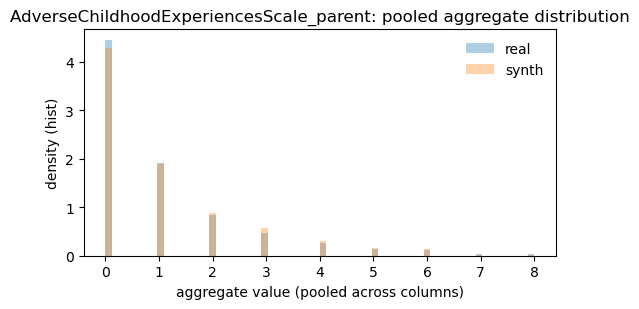

,dataset,n_corr_cols,mean_abs_corr_diff,max_abs_corr_diff,fro_norm_corr_diff
0,AdverseChildhoodExperiencesScale_parent,0,NaN,NaN,NaN


,dataset,rows_real,cols_real,rows_synth,cols_synth,same_column_order
0,ChildBehaviorChecklist_parentPreschool,161,31,161,31,True


,col,missing_rate_real,missing_rate_synth,delta_missing_rate,mean_real,mean_synth,rel_delta_mean,std_real,std_synth,rel_delta_std
20,ChildBehaviorChecklist_parentPreschool__CBCL_P...,0.0,0.0,0.0,12.689441,13.565217,0.069016,8.721551,9.701020,0.112304
8,ChildBehaviorChecklist_parentPreschool__CBCL_P...,0.0,0.0,0.0,3.472050,3.633540,0.046512,3.244345,3.425437,0.055818
21,ChildBehaviorChecklist_parentPreschool__CBCL_P...,0.0,0.0,0.0,2.453416,2.559006,0.043038,2.926069,3.447544,0.178217
25,ChildBehaviorChecklist_parentPreschool__CBCL_P...,0.0,0.0,0.0,48.490683,50.236025,0.035993,29.886267,32.432144,0.085185
0,ChildBehaviorChecklist_parentPreschool__CBCL_P...,0.0,0.0,0.0,14.372671,14.869565,0.034572,8.987366,9.165240,0.019792
2,ChildBehaviorChecklist_parentPreschool__CBCL_P...,0.0,0.0,0.0,3.645963,3.770186,0.034072,3.151210,3.305769,0.049047
6,ChildBehaviorChecklist_parentPreschool__CBCL_P...,0.0,0.0,0.0,6.366460,6.534161,0.026341,3.362829,3.341091,-0.006464
10,ChildBehaviorChecklist_parentPreschool__CBCL_P...,0.0,0.0,0.0,4.869565,4.745342,-0.025510,4.168529,4.450112,0.067550


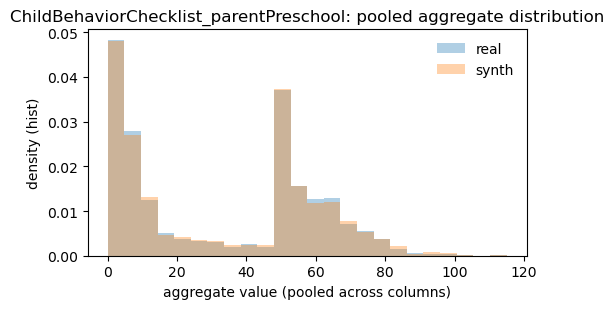

,dataset,n_corr_cols,mean_abs_corr_diff,max_abs_corr_diff,fro_norm_corr_diff
0,ChildBehaviorChecklist_parentPreschool,29,0.056006,0.180093,1.965


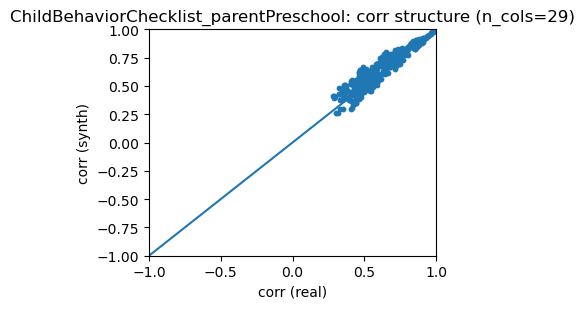

,dataset,rows_real,cols_real,rows_synth,cols_synth,same_column_order
0,ChildBehaviorChecklist_parent,4301,26,4301,26,True


,col,missing_rate_real,missing_rate_synth,delta_missing_rate,mean_real,mean_synth,rel_delta_mean,std_real,std_synth,rel_delta_std
23,ChildBehaviorChecklist_parent__CBCL_CBCL_WD_T,0.001163,0.000930,-0.000233,58.246508,58.068653,-0.003054,8.663277,8.450463,-0.024565
10,ChildBehaviorChecklist_parent__CBCL_CBCL_Int_T,0.001163,0.000930,-0.000233,56.607542,56.520828,-0.001532,11.298947,11.280766,-0.001609
3,ChildBehaviorChecklist_parent__CBCL_CBCL_AD_T,0.001163,0.000930,-0.000233,58.150372,58.230393,0.001376,8.811819,8.839505,0.003142
17,ChildBehaviorChecklist_parent__CBCL_CBCL_SP_T,0.001163,0.000930,-0.000233,58.204143,58.222946,0.000323,7.931106,7.860285,-0.008929
1,ChildBehaviorChecklist_parent__CBCL_CBCL_AB_T,0.001163,0.000930,-0.000233,58.689711,58.702816,0.000223,9.405933,9.411198,0.000560
5,ChildBehaviorChecklist_parent__CBCL_CBCL_AP_T,0.001163,0.000930,-0.000233,62.904330,62.894810,-0.000151,9.765799,10.024579,0.026499
22,ChildBehaviorChecklist_parent__CBCL_CBCL_WD,0.000233,0.000000,-0.000233,2.666744,2.608231,-0.021942,2.858834,2.771318,-0.030613
15,ChildBehaviorChecklist_parent__CBCL_CBCL_SC_T,0.001395,0.001163,-0.000233,57.460768,57.304469,-0.002720,7.781978,7.786675,0.000604


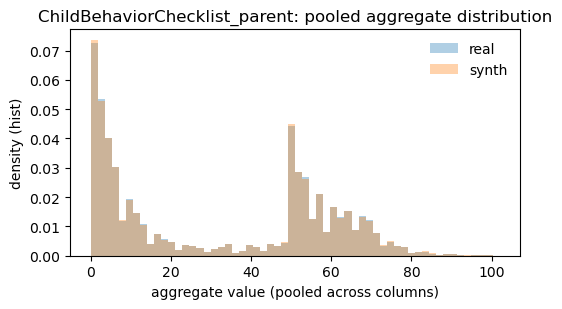

,dataset,n_corr_cols,mean_abs_corr_diff,max_abs_corr_diff,fro_norm_corr_diff
0,ChildBehaviorChecklist_parent,24,0.006597,0.028716,0.200217


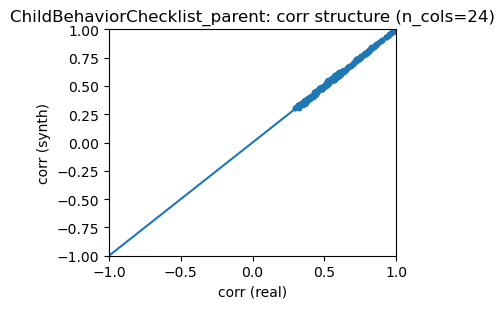

,dataset,rows_real,cols_real,rows_synth,cols_synth,same_column_order
0,ChildrensDepressionInventory_child,175,16,175,16,True


,col,missing_rate_real,missing_rate_synth,delta_missing_rate,mean_real,mean_synth,rel_delta_mean,std_real,std_synth,rel_delta_std
6,ChildrensDepressionInventory_child__CDI_SR_CDI...,0.0,0.0,0.0,1.577143,1.405714,-0.108696,1.891768,1.755442,-0.072063
2,ChildrensDepressionInventory_child__CDI_SR_CDI...,0.0,0.0,0.0,6.182857,5.640000,-0.087800,4.608930,4.438805,-0.036912
8,ChildrensDepressionInventory_child__CDI_SR_CDI...,0.0,0.0,0.0,3.657143,3.354286,-0.082812,3.099340,3.075706,-0.007626
4,ChildrensDepressionInventory_child__CDI_SR_CDI...,0.0,0.0,0.0,4.605714,4.234286,-0.080645,3.131041,3.041281,-0.028668
12,ChildrensDepressionInventory_child__CDI_SR_CDI...,0.0,0.0,0.0,11.428571,10.520000,-0.079500,8.536217,8.260027,-0.032355
0,ChildrensDepressionInventory_child__CDI_SR_CDI...,0.0,0.0,0.0,5.245714,4.880000,-0.069717,4.629015,4.436318,-0.041628
10,ChildrensDepressionInventory_child__CDI_SR_CDI...,0.0,0.0,0.0,1.588571,1.525714,-0.039568,2.269712,2.159760,-0.048443
3,ChildrensDepressionInventory_child__CDI_SR_CDI...,0.0,0.0,0.0,57.588571,56.062857,-0.026493,13.288223,12.616425,-0.050556


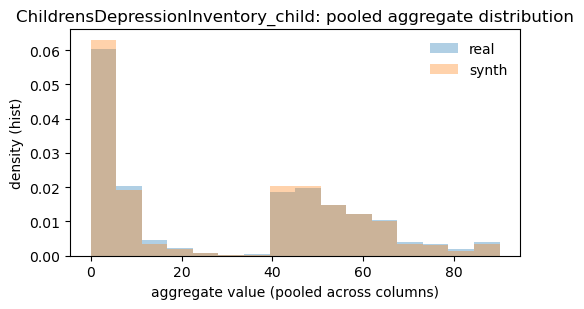

,dataset,n_corr_cols,mean_abs_corr_diff,max_abs_corr_diff,fro_norm_corr_diff
0,ChildrensDepressionInventory_child,14,0.014196,0.055877,0.250984


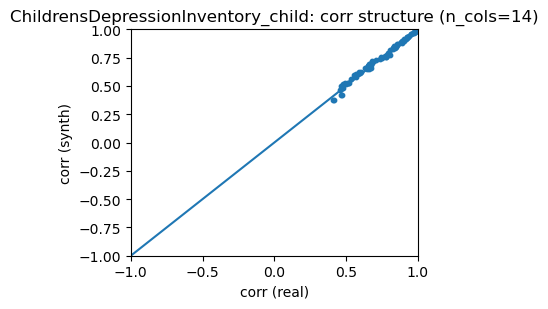

,dataset,rows_real,cols_real,rows_synth,cols_synth,same_column_order
0,ChildrensDepressionInventory_parent,210,8,210,8,True


,col,missing_rate_real,missing_rate_synth,delta_missing_rate,mean_real,mean_synth,rel_delta_mean,std_real,std_synth,rel_delta_std
0,ChildrensDepressionInventory_parent__CDI_P_CDI...,0.019048,0.038095,0.019048,5.951456,5.217822,-0.123270,4.686001,4.134803,-0.117627
4,ChildrensDepressionInventory_parent__CDI_P_CDI...,0.019048,0.038095,0.019048,15.407767,14.836634,-0.037068,8.176035,8.310399,0.016434
1,ChildrensDepressionInventory_parent__CDI_P_CDI...,0.019048,0.038095,0.019048,53.519417,51.806931,-0.031997,11.897412,10.880507,-0.085473
2,ChildrensDepressionInventory_parent__CDI_P_CDI...,0.019048,0.038095,0.019048,9.456311,9.618812,0.017184,4.738584,5.340006,0.126920
5,ChildrensDepressionInventory_parent__CDI_P_CDI...,0.019048,0.038095,0.019048,56.723301,55.940594,-0.013799,11.431072,11.749307,0.027839
3,ChildrensDepressionInventory_parent__CDI_P_CDI...,0.019048,0.038095,0.019048,58.631068,58.816832,0.003168,11.918414,13.362944,0.121202


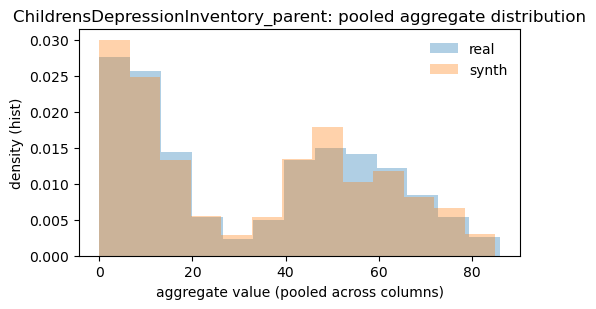

,dataset,n_corr_cols,mean_abs_corr_diff,max_abs_corr_diff,fro_norm_corr_diff
0,ChildrensDepressionInventory_parent,6,0.022407,0.03768,0.139315


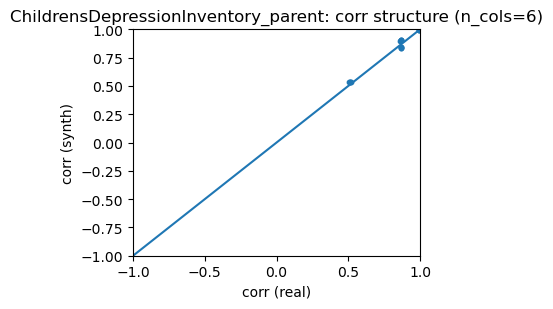

,dataset,rows_real,cols_real,rows_synth,cols_synth,same_column_order
0,ConnersADHDRatingScales,3256,14,3256,14,True


,col,missing_rate_real,missing_rate_synth,delta_missing_rate,mean_real,mean_synth,rel_delta_mean,std_real,std_synth,rel_delta_std
0,ConnersADHDRatingScales__C3SR_C3SR_AG,0.000307,0.0,-0.000307,2.526882,2.610258,0.032996,2.756085,2.866643,0.040114
11,ConnersADHDRatingScales__C3SR_C3SR_PI,0.000307,0.0,-0.000307,0.791705,0.779791,-0.015048,1.067019,1.065751,-0.001189
1,ConnersADHDRatingScales__C3SR_C3SR_AG_T,0.000307,0.0,-0.000307,56.661444,57.077703,0.007346,14.401510,14.834420,0.030060
2,ConnersADHDRatingScales__C3SR_C3SR_FR,0.000307,0.0,-0.000307,3.487865,3.470516,-0.004974,3.628122,3.616958,-0.003077
3,ConnersADHDRatingScales__C3SR_C3SR_FR_T,0.000307,0.0,-0.000307,53.800922,53.725430,-0.001403,12.508080,12.434758,-0.005862
10,ConnersADHDRatingScales__C3SR_C3SR_NI,0.000000,0.0,0.000000,0.926290,0.913698,-0.013594,1.130815,1.103096,-0.024513
8,ConnersADHDRatingScales__C3SR_C3SR_LP,0.000000,0.0,0.000000,5.371622,5.303440,-0.012693,3.813966,3.811060,-0.000762
6,ConnersADHDRatingScales__C3SR_C3SR_IN,0.000000,0.0,0.000000,8.685811,8.648956,-0.004243,4.827901,4.807628,-0.004199


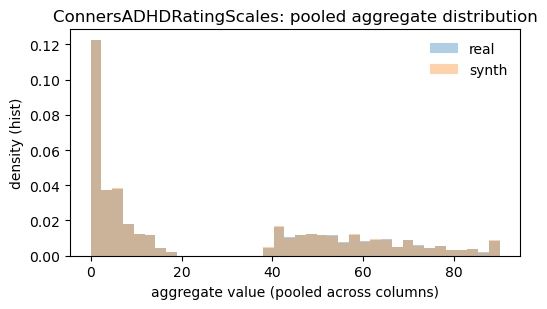

,dataset,n_corr_cols,mean_abs_corr_diff,max_abs_corr_diff,fro_norm_corr_diff
0,ConnersADHDRatingScales,12,0.01098,0.027558,0.160252


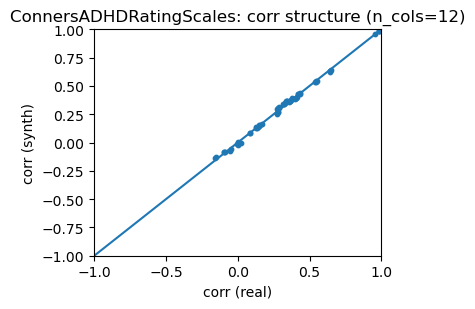

,dataset,rows_real,cols_real,rows_synth,cols_synth,same_column_order
0,ConnersAdultADHDRatingScales,121,12,121,12,True


,col,missing_rate_real,missing_rate_synth,delta_missing_rate,mean_real,mean_synth,rel_delta_mean,std_real,std_synth,rel_delta_std
6,ConnersAdultADHDRatingScales__CAARS_CAARS_IM_Raw,0.000000,0.000000,0.0,7.140496,6.578512,-0.078704,4.139859,4.047123,-0.022401
4,ConnersAdultADHDRatingScales__CAARS_CAARS_IE_Raw,0.008264,0.008264,0.0,4.500000,4.700000,0.044444,3.188741,3.247753,0.018506
2,ConnersAdultADHDRatingScales__CAARS_CAARS_HR_Raw,0.000000,0.000000,0.0,7.677686,7.347107,-0.043057,3.500512,3.625628,0.035742
0,ConnersAdultADHDRatingScales__CAARS_CAARS_ADHD...,0.000000,0.000000,0.0,14.024793,13.462810,-0.040071,7.566883,7.603772,0.004875
7,ConnersAdultADHDRatingScales__CAARS_CAARS_IM_T,0.008264,0.008264,0.0,56.141667,54.258333,-0.033546,13.220366,12.733530,-0.036825
3,ConnersAdultADHDRatingScales__CAARS_CAARS_HR_T,0.008264,0.008264,0.0,52.675000,51.591667,-0.020566,10.879912,10.999997,0.011037
1,ConnersAdultADHDRatingScales__CAARS_CAARS_ADHD_T,0.008264,0.008264,0.0,53.383333,52.441667,-0.017640,12.934992,12.886574,-0.003743
5,ConnersAdultADHDRatingScales__CAARS_CAARS_IE_T,0.008264,0.008264,0.0,50.283333,50.925000,0.012761,10.282712,10.599003,0.030759


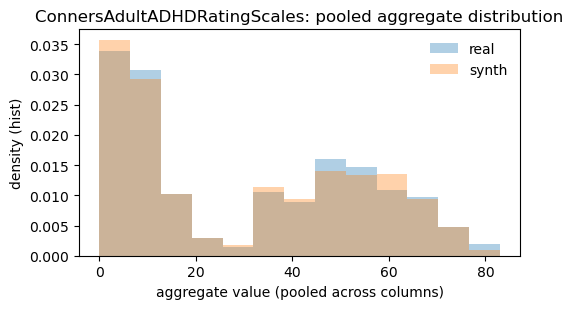

,dataset,n_corr_cols,mean_abs_corr_diff,max_abs_corr_diff,fro_norm_corr_diff
0,ConnersAdultADHDRatingScales,10,0.038343,0.076723,0.4098


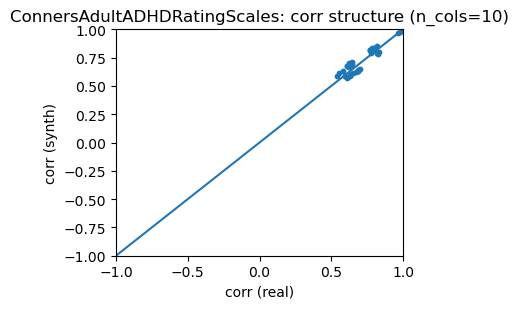

,dataset,rows_real,cols_real,rows_synth,cols_synth,same_column_order
0,NegativeLifeEventsScale_child,1251,6,1251,6,True


,col,missing_rate_real,missing_rate_synth,delta_missing_rate,mean_real,mean_synth,rel_delta_mean,std_real,std_synth,rel_delta_std
2,NegativeLifeEventsScale_child__NLES_SR_NLES_SR...,0.027978,0.021583,-0.006395,2.920962,2.908333,-0.004324,1.177469,1.111702,-0.055855
3,NegativeLifeEventsScale_child__NLES_SR_NLES_SR...,0.000000,0.000000,0.000000,14.933653,15.318145,0.025747,11.840456,12.184494,0.029056
0,NegativeLifeEventsScale_child__NLES_SR_NLES_SR...,0.000000,0.000000,0.000000,4.831335,4.932054,0.020847,3.275046,3.336972,0.018908
1,NegativeLifeEventsScale_child__NLES_SR_NLES_SR...,0.000000,0.000000,0.000000,7.355715,7.505995,0.020430,5.501469,5.630254,0.023409


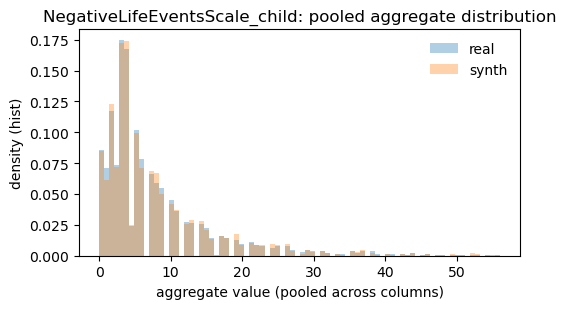

,dataset,n_corr_cols,mean_abs_corr_diff,max_abs_corr_diff,fro_norm_corr_diff
0,NegativeLifeEventsScale_child,4,0.023576,0.050385,0.105278


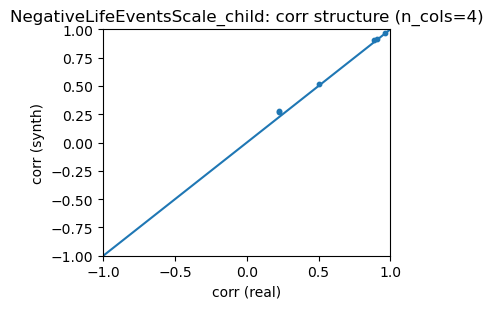

,dataset,rows_real,cols_real,rows_synth,cols_synth,same_column_order
0,NegativeLifeEventsScale_parent,4148,6,4148,6,True


,col,missing_rate_real,missing_rate_synth,delta_missing_rate,mean_real,mean_synth,rel_delta_mean,std_real,std_synth,rel_delta_std
2,NegativeLifeEventsScale_parent__NLES_P_NLES_P_...,0.005545,0.007473,0.001929,20.040584,34.070357,0.700068,1027.136040,1443.520511,0.405384
1,NegativeLifeEventsScale_parent__NLES_P_NLES_P_...,0.000000,0.000000,0.000000,6.423095,6.472276,0.007657,3.305244,3.285316,-0.006029
0,NegativeLifeEventsScale_parent__NLES_P_NLES_P_...,0.000000,0.000000,0.000000,5.081485,5.094021,0.002467,2.922620,2.906274,-0.005593
3,NegativeLifeEventsScale_parent__NLES_P_NLES_P_...,0.000000,0.000000,0.000000,15.103664,15.105111,0.000096,10.841576,10.776890,-0.005967


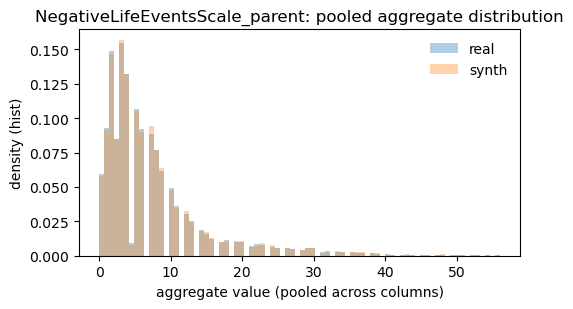

,dataset,n_corr_cols,mean_abs_corr_diff,max_abs_corr_diff,fro_norm_corr_diff
0,NegativeLifeEventsScale_parent,4,0.005344,0.010208,0.022647


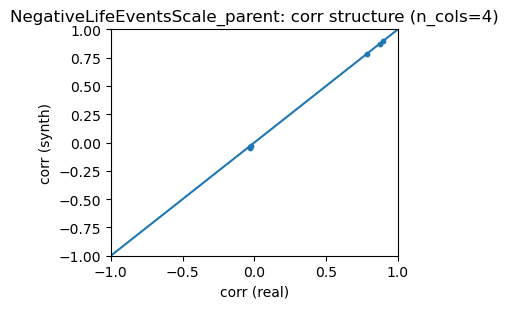

,dataset,rows_real,cols_real,rows_synth,cols_synth,same_column_order
0,ScreenForChildAnxietyRelatedDisorders_child,3187,8,3187,8,True


,col,missing_rate_real,missing_rate_synth,delta_missing_rate,mean_real,mean_synth,rel_delta_mean,std_real,std_synth,rel_delta_std
1,ScreenForChildAnxietyRelatedDisorders_child__S...,0.000314,0.0,-0.000314,5.255179,5.150926,-0.019838,5.477900,5.300286,-0.032424
2,ScreenForChildAnxietyRelatedDisorders_child__S...,0.000314,0.0,-0.000314,5.472693,5.486665,0.002553,3.879833,3.840437,-0.010154
3,ScreenForChildAnxietyRelatedDisorders_child__S...,0.000314,0.0,-0.000314,1.964218,1.968309,0.002082,1.997952,1.998100,0.000074
4,ScreenForChildAnxietyRelatedDisorders_child__S...,0.000000,0.0,0.000000,4.740195,4.697835,-0.008936,3.928939,3.907677,-0.005412
5,ScreenForChildAnxietyRelatedDisorders_child__S...,0.000000,0.0,0.000000,22.969564,22.816128,-0.006680,16.287091,15.878701,-0.025074
0,ScreenForChildAnxietyRelatedDisorders_child__S...,0.000000,0.0,0.000000,5.541261,5.512394,-0.005210,4.707826,4.668827,-0.008284


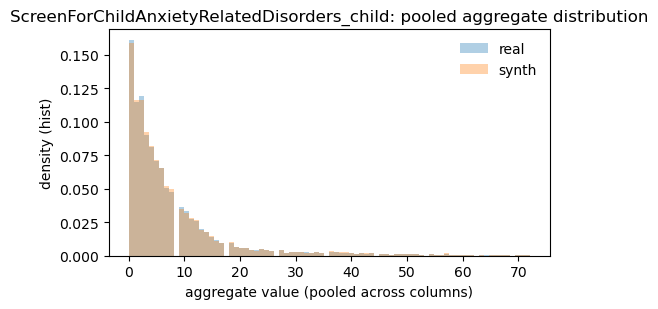

,dataset,n_corr_cols,mean_abs_corr_diff,max_abs_corr_diff,fro_norm_corr_diff
0,ScreenForChildAnxietyRelatedDisorders_child,6,0.015077,0.03028,0.091657


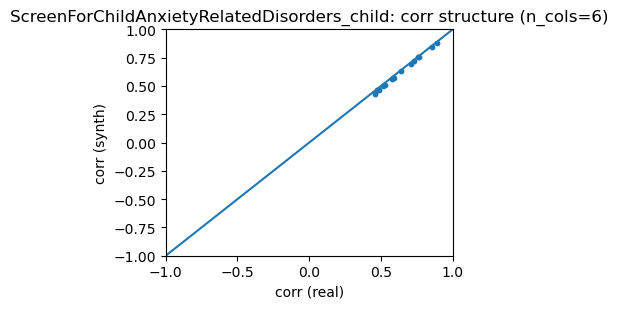

,dataset,rows_real,cols_real,rows_synth,cols_synth,same_column_order
0,ScreenForChildAnxietyRelatedDisorders_parent,4177,8,4177,8,True


,col,missing_rate_real,missing_rate_synth,delta_missing_rate,mean_real,mean_synth,rel_delta_mean,std_real,std_synth,rel_delta_std
3,ScreenForChildAnxietyRelatedDisorders_parent__...,0.950682,0.947331,-0.003352,58.631068,58.368182,-0.004484,11.918414,10.997546,-0.077264
5,ScreenForChildAnxietyRelatedDisorders_parent__...,0.950682,0.947331,-0.003352,56.723301,56.513636,-0.003696,11.431072,10.751863,-0.059418
1,ScreenForChildAnxietyRelatedDisorders_parent__...,0.950682,0.947331,-0.003352,53.519417,53.345455,-0.003250,11.897412,11.467991,-0.036094
2,ScreenForChildAnxietyRelatedDisorders_parent__...,0.950682,0.947331,-0.003352,9.456311,9.427273,-0.003071,4.738584,4.370844,-0.077606
4,ScreenForChildAnxietyRelatedDisorders_parent__...,0.950682,0.947331,-0.003352,15.407767,15.386364,-0.001389,8.176035,7.700489,-0.058163
0,ScreenForChildAnxietyRelatedDisorders_parent__...,0.950682,0.947331,-0.003352,5.951456,5.959091,0.001283,4.686001,4.537330,-0.031727


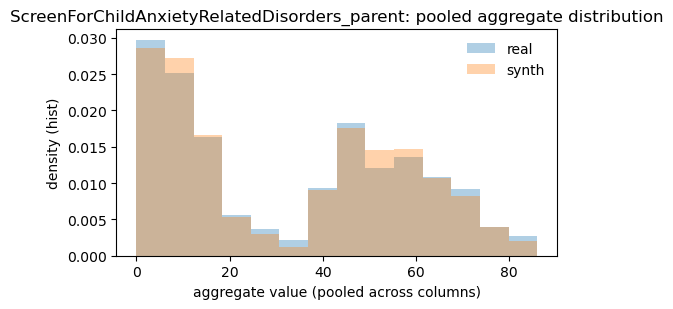

,dataset,n_corr_cols,mean_abs_corr_diff,max_abs_corr_diff,fro_norm_corr_diff
0,ScreenForChildAnxietyRelatedDisorders_parent,6,0.007338,0.019462,0.051509


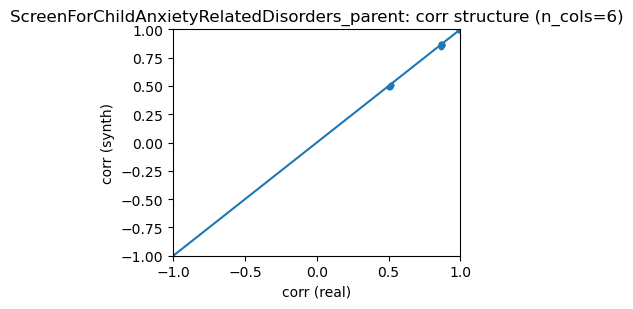

,dataset,rows_real,cols_real,rows_synth,cols_synth,same_column_order
0,StateTraitAnxietyInventory,73,8,73,8,True


,col,missing_rate_real,missing_rate_synth,delta_missing_rate,mean_real,mean_synth,rel_delta_mean,std_real,std_synth,rel_delta_std
1,StateTraitAnxietyInventory__STAI_STAI_SA_P,0.0,0.0,0.0,62.972603,63.945205,0.015445,30.550492,29.421690,-0.036949
3,StateTraitAnxietyInventory__STAI_STAI_TA,0.0,0.0,0.0,44.958904,44.726027,-0.005180,14.310484,13.837610,-0.033044
4,StateTraitAnxietyInventory__STAI_STAI_TA_P,0.0,0.0,0.0,70.342466,70.698630,0.005063,30.969617,31.259969,0.009375
5,StateTraitAnxietyInventory__STAI_STAI_TA_T,0.0,0.0,0.0,59.520548,59.287671,-0.003913,14.792180,14.279433,-0.034663
0,StateTraitAnxietyInventory__STAI_STAI_SA,0.0,0.0,0.0,41.684932,41.575342,-0.002629,13.074441,12.312954,-0.058242
2,StateTraitAnxietyInventory__STAI_STAI_SA_T,0.0,0.0,0.0,54.904110,54.780822,-0.002246,12.272558,11.495466,-0.063319


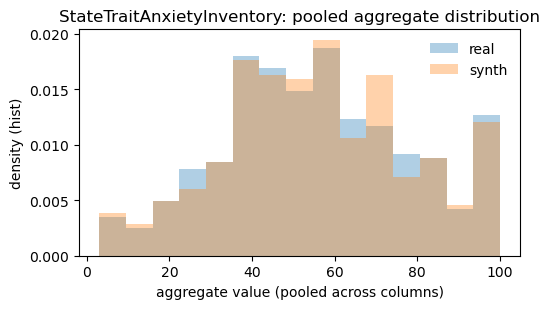

,dataset,n_corr_cols,mean_abs_corr_diff,max_abs_corr_diff,fro_norm_corr_diff
0,StateTraitAnxietyInventory,6,0.007642,0.015861,0.049087


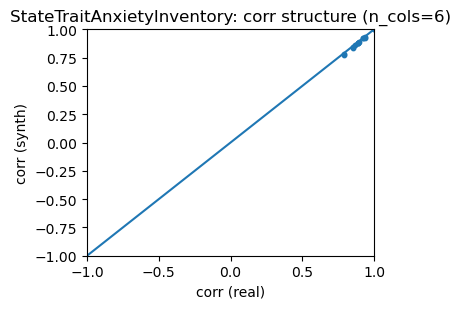

In [56]:
run_all_pairs(pairs, top_k=8, show_corr=True, min_corr_nonmissing=50, dist_mode="hist")